# Calculating the percentage of canceled orders

This notebook contains the calculation of the percentage of canceled orders from Olist. Also validating the hypotesis that says `one order that was canceled has a review note less than 3`

In [74]:
from pyspark.sql import SparkSession, functions as F
import seaborn as sns; sns.set(color_codes=True)

In [76]:
spark = SparkSession.builder.getOrCreate()

## Reading files and joining DFs

In [77]:
orders_df = spark.read \
                 .option('quote', '\"') \
                 .option('escape', '\"') \
                 .csv('./dataset/olist_orders_dataset.csv', header=True, multiLine=True)

In [78]:
order_reviews_df = spark.read \
                 .option('quote', '\"') \
                 .option('escape', '\"') \
                 .csv('./dataset/olist_order_reviews_dataset.csv', header=True, multiLine=True)

In [109]:
df = orders_df.join(order_reviews_df, orders_df.order_id == order_reviews_df.order_id)
df.groupBy('order_status').count().show()

+------------+-----+
|order_status|count|
+------------+-----+
|     shipped| 1118|
|    canceled|  629|
|    approved|    2|
|    invoiced|  318|
|     created|    5|
|   delivered|97015|
| unavailable|  611|
|  processing|  302|
+------------+-----+



## Calculating percentage of canceled orders

In [81]:
canceled_orders_df = df.where(F.col('order_status') == 'canceled')
total_canceled = canceled_orders_df.count()
percentage_canceled = (total_canceled / df.count()) * 100
print('The percentage of canceled orders is: {0:.2f}%'.format(percentage_canceled))

The percentage of canceled orders is: 0.63%


In [108]:
canceled_orders_df.limit(5).toPandas()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,f79644ec98219489ae16ee7aabac4ebb,15d1752086d06a721b7842591ce41eb8,canceled,2018-05-05 13:36:10,2018-05-05 13:50:25,None,None,2018-05-17 00:00:00,805298fb462e582a5d24b11e763cfcf4,f79644ec98219489ae16ee7aabac4ebb,5,None,EU NÃO RECEBI O PRODUTO POIS O VENDEDOR NÃO PO...,2018-05-19 00:00:00,2018-05-21 12:32:09
1,3a129877493c8189c59c60eb71d97c29,0913cdce793684e52bbfac69d87e91fd,canceled,2018-01-25 13:34:24,2018-01-25 13:50:20,2018-01-26 21:42:18,None,2018-02-23 00:00:00,15c8f3b3ff412d0f8d6b72053335fd0b,3a129877493c8189c59c60eb71d97c29,1,None,Não recebi o produto e também não tive reembolso,2018-02-25 00:00:00,2018-02-25 11:02:38
2,fa6d0c0ef7a7849ab7847303d458df3c,1ec1771954d299bf9a497cec57932c3d,canceled,2018-02-05 14:32:21,2018-02-05 14:48:31,None,None,2018-03-14 00:00:00,fcc5c9242321a4e6c564bced7e4af8cf,fa6d0c0ef7a7849ab7847303d458df3c,1,None,None,2018-03-16 00:00:00,2018-03-16 15:53:44
3,0a0e76ba55e310fd24657a1f532b97c1,faf4c7a6a07938227b98f454caee1814,canceled,2018-06-24 14:49:59,2018-06-24 15:18:57,None,None,2018-07-20 00:00:00,3fc3a51ee4c3103dbb5ec0f505703457,0a0e76ba55e310fd24657a1f532b97c1,1,Aguardando,"É a segunda vez que compro o mesmo produto, a ...",2018-07-22 00:00:00,2018-07-24 10:21:50
4,227c804e2a44760671a6a5697ea549e4,62e7477e75e542243ee62a0ba73f410f,canceled,2017-09-28 15:02:56,None,None,None,2017-10-16 00:00:00,c00b1a92c8643de86fef532ea9f244e9,227c804e2a44760671a6a5697ea549e4,1,None,acredito que a compra tenha sido cancelada.,2017-10-18 00:00:00,2017-10-18 13:56:27


## Calculating mean review score

In [110]:
review_score_mean = canceled_orders_df.select(F.mean('review_score'))
review_score_mean.show()

+------------------+
| avg(review_score)|
+------------------+
|1.8108108108108107|
+------------------+



## Ploting KDE

In [85]:
canceled_orders_df.groupBy('review_score').count().orderBy('review_score').show()

+------------+-----+
|review_score|count|
+------------+-----+
|           1|  436|
|           2|   45|
|           3|   50|
|           4|   27|
|           5|   71|
+------------+-----+



In [111]:
percentage_per_score = canceled_orders_df.select('review_score') \
                       .toPandas().astype(int)['review_score'].value_counts(normalize=True)

In [112]:
ppscore_less_than_3 = percentage_per_score[[1, 2]].sum(axis=0) * 100
ppscore_greater_than_3 = percentage_per_score[[3, 4, 5]].sum(axis=0) * 100

print('The percentage of review\'s score < 3 is: {0:.2f}%'.format(ppscore_less_than_3))
print('The percentage of review\'s score ≥ 3 is: {0:.2f}%'.format(ppscore_greater_than_3))

The percentage of review's score < 3 is: 76.47%
The percentage of review's score ≥ 3 is: 23.53%


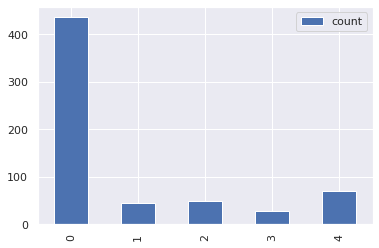

In [113]:
canceled_orders_df.groupBy('review_score').count().orderBy('review_score').toPandas().plot(kind="bar")

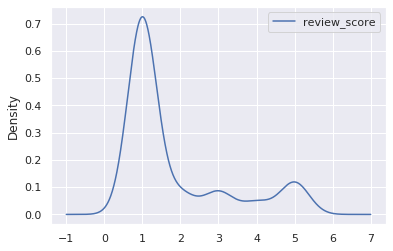

In [114]:
canceled_orders_df.select('review_score').toPandas().astype(int).plot.kde()

# Conclusion

## Hypoteses is valid, as the average of the review's score is below 3.